# Import needed packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors.kde import KernelDensity
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn import svm
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preparation 

## dummy variable for categorical data

In [2]:
# read in and prepare X_train, y_train and X_test data
X_train=pd.read_csv('MLProjectData.csv')
X_test=pd.read_csv('testData.csv',index_col=0) # test data has index needed to remove

# get test data
y_train = X_train['target']
X_train.drop('target',axis=1,inplace=True)

# label to split the training and testing
X_train['train']=True
X_test['train']=False
# get_dummies to encode categorical variables
temp=pd.get_dummies(X_train.append(X_test,sort=False))
X_train=temp[temp['train']==True].drop('train',axis=1)
X_test=temp[temp['train']==False].drop('train',axis=1)

## Standardize/Normalize
for non tree models such as SVR

In [5]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)

norm = Normalizer()
X_train_norm = norm.fit_transform(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [29]:
# normalize test data to output the result
X_test_norm = norm.transform(X_test)

# Benchmark 

## median and mean

In [96]:
y_train.describe()

count    6350.000000
mean       20.035933
std         1.419549
min         8.479981
25%        19.453096
50%        20.062500
75%        20.680000
max        32.849998
Name: target, dtype: float64

In [117]:
y_mean=np.repeat(y_train.mean(), len(y_train))
y_median=np.repeat(y_train.median(), len(y_train))
print('Benchmark\nMean:\nR2:',r2_score(y_train, y_mean)) 
print('MAE:',mae(y_train, y_mean)) 
print('Median:\nR2:',r2_score(y_train, y_median)) 
print('MAE:',mae(y_train, y_median)) 

Benchmark
Mean:
R2: 1.1102230246251565e-16
MAE: 0.9567985025831722
Median:
R2: -0.0003503183503301699
MAE: 0.9563565006299212


## kernel density

In [91]:
y_train_array = y_train.values[:,np.newaxis]

kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(y_train_array)
kde.score_samples(y_train_array)

print('MAE:',mae(y_train_array,kde.sample(len(y_train_array)))) 

MAE: 1.4492191158844947


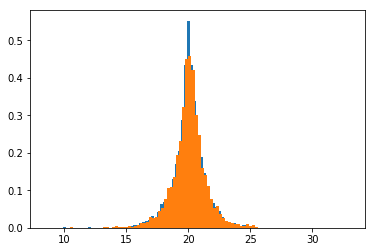

In [94]:
# Visualize the target
plt.hist(y_train,bins=100,density=0.5);
# y_train.quantile(q=0.05)
# y_train.quantile(q=0.95)
plt.hist(kde.sample(len(y_train_array)),bins=100,density=0.5);

# SVR

## Grid Search

In [37]:
# Dont run takes 90+ minutes

svr_grid = svm.SVR()

params_svr = {'C': [0.0001,0.001,0.005,0.1,0.3,0.5,1,3,5], 
              'gamma': [5,4,3,2,1.5,1,0.9,0.8,0.5],
              'kernel': ['rbf']}

grid_svr = GridSearchCV(svr_grid, params_svr,cv=10)
grid_svr.fit(X_train_norm, y_train)

# Print the MAE score
# print('Training MAE:', mae(y_train, grid_svr.best_estimator_.predict(X_train_norm)))

Training MAE: 0.9563635396782749


## Gridsearch results (candidates)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.5,
kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
  
SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=5,
kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## Cross Validation best model

### Standardized Data

In [6]:
svr_validate = svm.SVR(C=3,degree=3,gamma=0.9,kernel='rbf')

scores = cross_val_score(svr_validate, X_train_std, y_train, cv=10, scoring = 'neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

[-0.98771723 -0.93132544 -1.00851058 -0.9137543  -0.89537944 -0.97483196
 -0.94677773 -0.99193567 -0.9394993  -0.97780779]
-0.9567539434416366


### Normalized Data (works better)

In [154]:
svr_validate = svm.SVR(C=3,degree=3,gamma=0.9,kernel='rbf')

scores = cross_val_score(svr_validate, X_train_norm, y_train, cv=10, scoring = 'neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

[-0.9908526  -0.93328811 -1.0075597  -0.91038571 -0.88694411 -0.97235694
 -0.94409592 -0.99034215 -0.94005804 -0.97752778]
-0.9553411052541234


### Output result

In [30]:
result = svr_final.predict(X_test_norm)

(array([12., 31., 18.,  2.,  6.,  2.,  2.,  1.,  1.,  2.]),
 array([20.06090585, 20.06534632, 20.06978679, 20.07422726, 20.07866773,
        20.0831082 , 20.08754867, 20.09198914, 20.09642961, 20.10087008,
        20.10531055]),
 <a list of 10 Patch objects>)

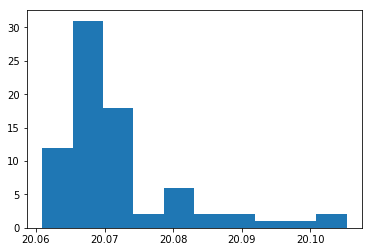

In [31]:
plt.hist(result)

In [32]:
len(result)

77

In [35]:
result.tofile('result.csv',sep='\n')

## PCA + SVR (unsuccessful try)

In [150]:
svr_grid = svm.SVR()

params_svr = {'C': [3,4,5,6,7,8], 
              'gamma': [5,4,3,2,1,0.5],
              'kernel': ['rbf']}

grid_svr = GridSearchCV(svr_grid, params_svr,cv=5)
grid_svr.fit(X_train_pca, y_train)

Training MAE: 0.11878177387367138


In [152]:
# Cross Validation
svr_validate = svm.SVR(C=4,degree=3,gamma=4,kernel='rbf')
# svr_validate = svm.SVR(gamma='auto')

scores = cross_val_score(svr_validate, X_train_pca, y_train, cv=10, scoring = 'neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

[-0.9878083  -0.93158894 -1.00834542 -0.9140054  -0.89540323 -0.97501114
 -0.94688645 -0.99214737 -0.93950996 -0.9777393 ]
-0.9568445504223
